# Debiasing using GenFocal

In this colab we provide a demo on how to use GenFocal for debiasing one year of a single LENS2 member using GenFocal.

Given that we seek to use the same model as in our paper, this colab is only suitable to run with a GPU/TPU with a relatively large memory. As such we suggest using either an instance with A100 or TPU V6e.

To `jit` compile the model and run longer debiasing we suggest to use a `H100` or a `TPU v5p`. For parallel inference we recommend using the `run_inference.py` script.

We install all the dependencies to run the code using ``pip``. If using ``colab`` with a ``TPU`` you may need to restart your kernel.

In [ ]:
!pip install git+https://github.com/google-research/swirl-dynamics.git@main
!pip install xarray zarr cartopy

We also import all the necessary dependencies

In [ ]:
# We allow JAX to allocate a greater portion of the memory (usually only 75%).
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from os import path as osp

import functools
import json

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
import seaborn as sns
from tqdm import tqdm

from swirl_dynamics.projects.genfocal.debiasing import dataloaders
from swirl_dynamics.projects.genfocal.debiasing import trainers
from swirl_dynamics.projects.genfocal.debiasing import utils
from swirl_dynamics.projects.genfocal.debiasing import inference_utils

# Defines shortened types
ConfigDict = ml_collections.config_dict.config_dict.ConfigDict

We also download all the necessary data to run this demo. The data consists mostly on climatologies computed for both LENS2 and ERA5, the input data and the checkpoints of the network.

We use gsutil for downloading the data. If you are running this notebook in colab, it should be already installed, otherwise, you can follow these [instructions](https://cloud.google.com/storage/docs/gsutil_install) to install it in your computer. Here we utilize `gsutil` with the `-m` and `-q` options. The former allows for multithreading, which substantially accelerate the downloading, while latter is used to avoid a large amount of text going into this notebook.

Another option is to interface directly with a Google Cloud bucket using the
`xarray` interface and `zarr` as a back end.

In [ ]:
# Downloads the climatology for LENS2 (it should take around 3-4 mins)
# Here we will only download the ones that have 10 variables and we only load
# 4 LENS2 members.
!mkdir climatology/
!gsutil -m -q cp -R gs://genfocal/bc/climatology/mean_lens2_240x121_10_vars_lonlat_clim_daily_1961_to_2000.zarr climatology/
!gsutil -m -q cp -R gs://genfocal/bc/climatology/std_lens2_240x121_10_vars_lonlat_clim_daily_1961_to_2000.zarr climatology/
!gsutil -m -q cp -R gs://genfocal/bc/climatology/lens2_240x121_10_vars_4_members_lonlat_clim_daily_1961_to_2000_31_dw.zarr climatology/

# Downloads the climatology for ERA5.
!gsutil -m -q cp -R gs://genfocal/bc/climatology/1p5deg_11vars_windspeed_1961-2000_daily_v2.zarr climatology/

# Downloads the checkpoints.
!gsutil -m -q cp -R gs://genfocal/bc/checkpoints .

In [ ]:
# We download a small portion of the data set, containing only two years and 4 members.
!gsutil -m -q cp -R gs://genfocal/staging/lens2/lens2_240x121_lonlat_2010-2011_10_vars_4_members.zarr .

# We also extract a small ERA5 slice.
!gsutil -m -q cp -R gs://genfocal/staging/era5/era5_240x121_lonlat_2010-2011_10_vars.zarr .

# GenFocal Debiasing

The debiasing step of GenFocal is **instantiated** using a Rectified Flow approach.

For a given sequence $y \in Y$, the debiasing steps to **debias** a sample $x \in X$ are as **follows**:

1.  Compute the climatology mean and standard deviation for the corresponding day of the year. (These are already **pre-computed** in the downloaded zarr files.)
2.  Normalize the sample using the climatology: $$\hat{y} = (y - \mu)/\sigma.$$ (This is performed at the dataloader level.)
3.  Perform the debiasing step by solving the ODE:
    $$\frac{d \hat{y}}{d \tau} = v_{\theta} (\hat{y}, \tau; \mu, \sigma)$$    with the initial condition$$\hat{y}(\tau = 0) = \hat{y}.$$
4.  Define the **debiased sample**, albeit still normalized,  as
    $$\hat{x} = \hat{y}(\tau = 1).$$
5.  Denormalize the debiased sample:
    $$x = \hat{x} \cdot \sigma_{\text{ERA5}} + \mu_{\text{ERA5}},$$
    using the ERA5 climatological mean and standard deviation.

The following section shows how to perform these steps. The algorithmic pipeline consists of the following:

* Load the configuration file for the model, including the neural architecture details, variables to-be-debiased, and dataloader details.
* Instantiate the dataloader.
* Instantiate the model and load the trained weights.
* Loop over the data to be debiased and solve the ODE.


Load the configuration file from the trained network. Here we load the json file within the checkpoints folder, which contains the description of the network as well as many of the training options using during training.

In [ ]:
current_directory = os.getcwd()
checkpoints_dir = "checkpoints/reflow_uvit"
with open(
    osp.join(current_directory, checkpoints_dir, "config.json"), "r"
) as f:
  args = json.load(f)
  if isinstance(args, str):
    args = json.loads(args)

# Loading the configurations for the ml-experiment.
config = ml_collections.ConfigDict(args)

We build the dataloader. Here we use the path from the data that was already loaded before.

In [ ]:
_ERA5_DATASET_PATH = "era5_240x121_lonlat_2010-2011_10_vars.zarr"
_ERA5_STATS_PATH = "climatology/1p5deg_11vars_windspeed_1961-2000_daily_v2.zarr"
_LENS2_DATASET_PATH = "lens2_240x121_lonlat_2010-2011_10_vars_4_members.zarr"
_LENS2_STATS_PATH = "climatology/lens2_240x121_10_vars_4_members_lonlat_clim_daily_1961_to_2000_31_dw.zarr"
_LENS2_MEAN_CLIMATOLOGY_PATH = (
    "climatology/mean_lens2_240x121_10_vars_lonlat_clim_daily_1961_to_2000.zarr"
)
_LENS2_STD_CLIMATOLOGY_PATH = (
    "climatology/std_lens2_240x121_10_vars_lonlat_clim_daily_1961_to_2000.zarr"
)

We will alse define the variables that will be debiased and

In [ ]:
_ERA5_VARIABLES = {
    "10m_magnitude_of_wind": None,
    "2m_temperature": None,
    "geopotential": {"level": [200, 500]},
    "mean_sea_level_pressure": None,
    "specific_humidity": {"level": 1000},
    "u_component_of_wind": {"level": [200, 850]},
    "v_component_of_wind": {"level": [200, 850]},
}

_LENS2_MEMBER_INDEXER = ({"member": "cmip6_1001_001"},)
_LENS2_VARIABLE_NAMES = (
    "WSPDSRFAV",
    "TREFHT",
    "Z200",
    "Z500",
    "PSL",
    "QREFHT",
    "U200",
    "U850",
    "V200",
    "V850",
)
_LENS2_VARIABLES = {
    v: {"member": "cmip6_1001_001"} for v in _LENS2_VARIABLE_NAMES
}

# Variable names for the output.
output_variables_names = [
    "10mW",
    "2mT",
    "200Z",
    "500Z",
    "MSL",
    "Q1000",
    "200hPaU",
    "850hPaU",
    "200hPaV",
    "850hPaV",
]

### Instantiating the Dataloader.

The dataloader extracts the data, reshapes it, and it applies a climatology normalization. It normalizes the climatology itself, and it bundles everything in a batch given by a dictionary containing the different elements.

Each batch will have the following keys that are necessary to solve the ODE:
- `x_0`: a sample from a member of LENS2
- `channel:mean`: the normalized climatological mean of LENS2
- `channel:std`: the normalized climatological std of LENS2

In addition we add a few extra variables for comparison
- `output_mean`: the climatological mean of ERA5 used to denormalize the output of the ODE solve
- `output_std`: the climatological std of ERA5 used to denormalize the output of the ODE solve

We also include a sample from ERA5 for comparison
- `x_1`: a sample from ERA5

Finally, we also include debugging information
- `input_mean`: the climatological mean of LENS2 used to normalize the input
- `input_std`: the climatological std of LENS2 used to normalize the input
- `input_member`: the key of the LENS2 member
- `input_time_stamp`: the time stamp of the input `x_0`
- `output_time_stamp`: the time stamp of the ''reference'' out put `x_1`

In [ ]:
date_range = ("2010", "2011")
# We are only generating one batch wich consistes on several consecutive
# snapshots.
batch_size = config.time_batch_size

dataloader = dataloaders.create_ensemble_lens2_era5_loader_with_climatology(
    date_range=(
        date_range[0],
        date_range[1],
    ),
    batch_size=batch_size,
    shuffle=False,
    input_dataset_path=_LENS2_DATASET_PATH,
    input_climatology=_LENS2_STATS_PATH,
    input_mean_stats_path=_LENS2_MEAN_CLIMATOLOGY_PATH,
    input_std_stats_path=_LENS2_STD_CLIMATOLOGY_PATH,
    input_variable_names=_LENS2_VARIABLE_NAMES,
    input_member_indexer=_LENS2_MEMBER_INDEXER,
    output_dataset_path=_ERA5_DATASET_PATH,  # add a dummy here.
    output_climatology=_ERA5_STATS_PATH,
    output_variables=_ERA5_VARIABLES,
    time_stamps=True,
    inference_mode=True,  # Using the inference dataset.
    num_epochs=1,  # This is the loops stops automatically.
)

# Keys of the fields necessary for sampling.
inference_keys = (
    "channel:mean",
    "channel:std",
    "output_mean",
    "output_std",
    "x_0",
)

## Initializing the model and loading the checkpoint with the trained weights.

Here we use the configuration file to build the model, and then we leverage `orbax` to load the model weights.

We obtain the model to evaluate
$$v_{\theta}(\hat{y}, \tau; \mu, \sigma)$$.

In [ ]:
print_config = False

# Extracts the configuration from the ConfigDict dictionaty.
model_config = utils.get_model_config(config)
# Builds the model from that configuration class.
model = utils.build_model_from_config(model_config)

We erase the descriptor folder, as it seems to cause some issues with the internals of colab.

In [ ]:
!rm -rf /content/checkpoints/reflow_uvit/300000/descriptor

In [ ]:
# Loads the checkpoint.
trained_state = trainers.TrainState.restore_from_orbax_ckpt(
    f"{current_directory}/checkpoints/reflow_uvit",
    step=None,
)

if print_config:
  from clu import parameter_overview

  print(
      parameter_overview.get_parameter_overview(
          trained_state.model_variables["params"]
      )
  )

## Defining the sampling function

In here we define the solver for the ODE
$$\frac{d \hat{y}}{d \tau} = v_{\theta} (\hat{y}, \tau; \mu, \sigma).$$

Most of the heavy lifting is done in the `sampling_from_batch` function. Here we just set up the call to $v_{\theta}$ and some other necessary parameters such as the number of samples.

In [ ]:
num_sampling_steps = 32  # @param
sampling_from_batch_partial = functools.partial(
    inference_utils.sampling_from_batch,
    model=model,
    trained_state=trained_state,
    num_sampling_steps=num_sampling_steps,
    time_chunk_size=config.time_batch_size,  # This is the time chunk size.
    time_to_channel=config.get("time_to_channel", False),
    reverse_flow=False,
)

# Debiasing a single 8-day sample.

As the size of model is quite large, compilation seems to break in an A100. So instead we run a single sample (which takes 8 minutes without compilation)

Here we extract one batch from the dataloader, and obverse the structure of it and we also see the shape of each of the fields. As we are debiasing a short sequence of 8 snapshot it should be the leading dimension. Also, we are using a 1.5° resolution snapshot with poles, which corresponed to a $240 \times 121$ grid. Finally, we are debiasing $10$ variables as defined above, so the trailing dimension of most field should be $10$.

In [ ]:
batch = next(iter(dataloader))
for key in batch:
  print(key, batch[key].shape)

We also extract the input and a sample of the output and we denormalize them.

In [ ]:
x_lens2 = batch["x_0"] * batch["input_std"] + batch["input_mean"]
# LENS and ERA5 have different units for the geopotential.
x_lens2 = x_lens2 * np.array(
    2 * [1.,] + 2 * [9.8,] + 6 * [1.0,]
).reshape(1, 1, 1, 10)
x_era5 = batch["x_1"] * batch["output_std"] + batch["output_mean"]

As the batch contains more fields that strictily necessary, we remove the
fields that are not necessary and solve the ODE for debiasing using the transformed function defined above.



In [ ]:
batch = {k: batch[k] for k in inference_keys}
out = sampling_from_batch_partial(batch)

# Plotting the Output.
Now we can plot the difference samples, of LENS2, ERA5 and the output of the debiasing step of GenFocal.

### Introducing auxiliary functions.

In [ ]:
def make_imshow_plot(
    ax,
    data: np.ndarray,
    lon_range: tuple[float, float] = (0, 360),
    lat_range: tuple[float, float] = (-90, 90),
    **kwargs
):
  im = ax.imshow(
      data,
      extent=[
          lon_range[0] - 180,
          lon_range[1] - 180,
          lat_range[0],
          lat_range[1],
      ],
      transform=ccrs.PlateCarree(central_longitude=180),
      **kwargs
  )
  ax.set_aspect("equal")
  ax.set_xlim([lon_range[0] - 180, lon_range[1] - 180])
  ax.set_ylim(lat_range)
  ax.coastlines(resolution="50m", linewidth=0.3, color="black")
  ax.add_feature(cfeature.OCEAN, color="white")
  ax.add_feature(cfeature.LAND, color="white")
  return im


def create_fig_and_grid():
  fig = plt.figure(figsize=(15, 28), dpi=250)
  gs = mpl.gridspec.GridSpec(
      10, 4,
      wspace=0.01,
      hspace=0.21,
      width_ratios=[1, 1, 1, 0.05],
      height_ratios=10 * [1,],
  )

  return fig, gs

### Plotting and Inspecting Generated Samples

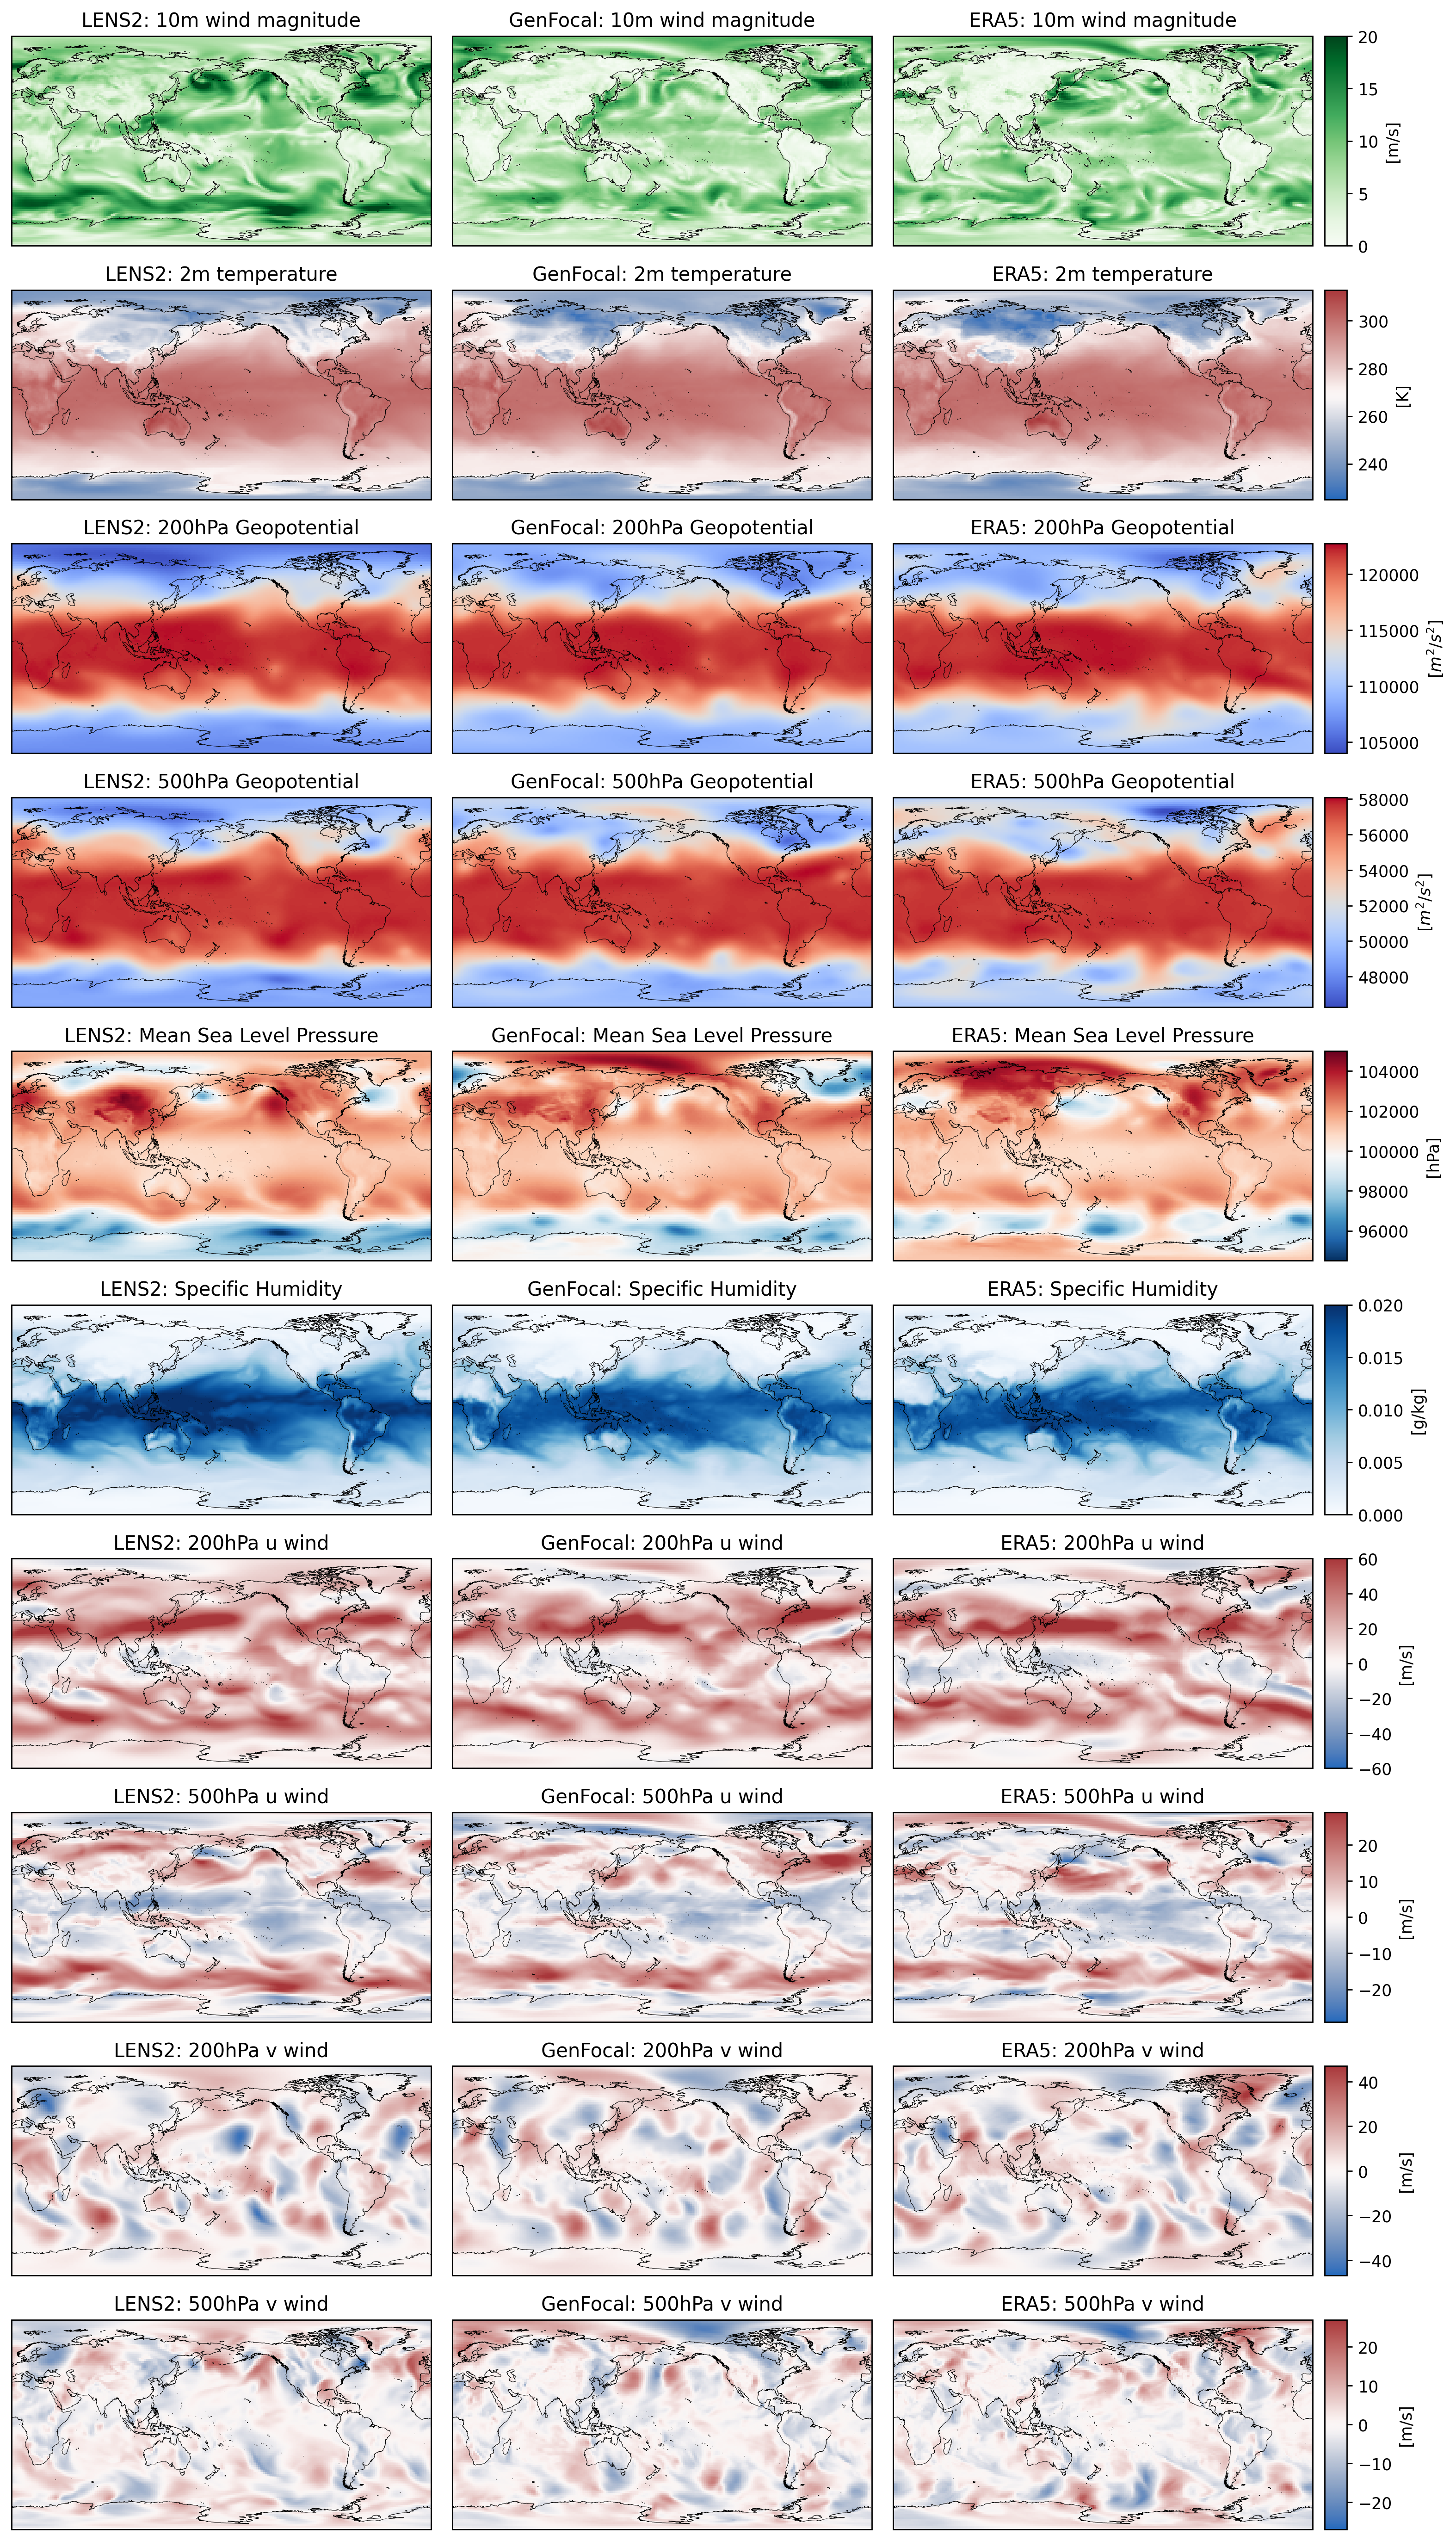

In [ ]:
idx_day = 1  # @param
fig, gs = create_fig_and_grid()
heat_cmap = sns.color_palette("vlag", as_cmap=True, n_colors=21)

# We store the fields, their index, unit and colormap, and values.
idx_field_dict = {
    "10m wind magnitude": (0, "[m/s]", "Greens", (0.0, 20.0)),
    "2m temperature": (1, "[K]", heat_cmap, (225.0, 313.0)),
    "200hPa Geopotential": (
        2, r"[$m^2/s^2$]", "coolwarm", (104000.0, 122735.0),
    ),
    "500hPa Geopotential": (3, r"[$m^2/s^2$]", "coolwarm", (46286.0, 58097.0)),
    "Mean Sea Level Pressure": (4, "[hPa]", "RdBu_r", (94500.0, 105000.0)),
    "Specific Humidity": (5, "[g/kg]", "Blues", (0.0, 0.02)),
    "200hPa u wind": (6, "[m/s]", heat_cmap, (-60.0, 60)),
    "500hPa u wind": (7, "[m/s]", heat_cmap, (-29.0, 29.0)),
    "200hPa v wind": (8, "[m/s]", heat_cmap, (-47.0, 47.0)),
    "500hPa v wind": (9, "[m/s]", heat_cmap, (-27.0, 27.0)),
}

for row, (field, (idx_field, unit, cmap, (vmin, vmax))) in enumerate(
    idx_field_dict.items()
):

  # LENS2
  ax = fig.add_subplot(
      gs[row, 0], projection=ccrs.PlateCarree(central_longitude=180)
  )
  _ = make_imshow_plot(ax, np.rot90(x_lens2[idx_day, :, :, idx_field]),
      cmap=cmap, vmin=vmin, vmax=vmax,
  )
  ax.set_title(f"LENS2: {field}")
  # GenFocal
  ax = fig.add_subplot(
      gs[row, 1], projection=ccrs.PlateCarree(central_longitude=180)
  )
  _ = make_imshow_plot(ax, np.rot90(out[idx_day, :, :, idx_field]),
      cmap=cmap, vmin=vmin, vmax=vmax,
  )
  ax.set_title(f"GenFocal: {field}")
  # ERA5
  ax = fig.add_subplot(
      gs[row, 2], projection=ccrs.PlateCarree(central_longitude=180)
  )
  im = make_imshow_plot(ax, np.rot90(x_era5[idx_day, :, :, idx_field]),
      cmap=cmap, vmin=vmin, vmax=vmax,
  )
  ax.set_title(f"ERA5: {field}")

  cax = fig.add_subplot(gs[row, 3])
  cbar = fig.colorbar(im, cax=cax)
  cbar.set_label(unit, fontsize=10)

From these images we can observe that GenFocal samples have similar features as the ones from the 'reference' dataset. As the debiasing step of GenFocal relies on a measure matching, there is not strong correspondance between the samples at this level of granularity. But as shown in the paper, they are able to capture the correct statistics of the target distribution.

### Sampling the full year (if a large GPU is present)

If a high memory GPU is available, such that the colab won't crash during compilation. Then we will compile the model, and run it for a full year. This may take a while.

In [ ]:
large_gpu = False

In [ ]:
if large_gpu:
  sampling_from_batch_partial_jitted = jax.jit(sampling_from_batch_partial)
  output_list = []
  time_stamps = []

  n_lon, n_lat, n_field = 121, 240, 10

  for ii, batch in tqdm(enumerate(dataloader)):
    time_stamps.append(batch["input_time_stamp"])
    batch = {k: batch[k] for k in inference_keys}

    # Running the parallel sampling and saving the output.
    samples = np.array(sampling_from_batch_partial_jitted(batch))
    samples = samples.reshape((-1, n_lon, n_lat, n_field))
    output_list.append(samples)

  output_array = np.concatenate(output_list, axis=0)